## Práctica 3 Parte A

### Alumno: Zhengkai Zhu

In [1]:
import sys
print(sys.version)

3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


In [2]:
!pip install -U qiskit-ibm-runtime
!pip install -U --no-cache-dir qiskit
!pip install -U qiskit-aer
!pip install -U pylatexenc

# Transformada de Fourier

Notebook para para entender el algoritmo de la Transformada de Fourier.
 Empezamos implementando el algoritmo de la **FFT** (**Fast Fourier Transform**) para encontrar el espectro de señales discretas de valores reales. Posteriormente implementamos la **QFT** (**Quantum Fourier Transform**) y su inversa para realizar conversiones entre señales de valores complejos y su descomposicion de Fourier.

Cargamos inicialmente las bibliotecas que vamos a necesitar.

In [2]:
import numpy as np
import math

## Import Qiskit
##from qiskit import QuantumCircuit, QuantumRegister
##from qiskit import Aer, transpile
##from qiskit.providers.aer import Aer, AerSimulator
##from qiskit.providers.fake_provider import FakeVigo

##from qiskit.visualization import array_to_latex
##from qiskit.tools.visualization import plot_histogram, plot_state_city
##import qiskit.quantum_info as qi



# nuevo Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings("ignore")

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram, plot_state_city, array_to_latex # plot_histogram is already imported earlier in the code, you can remove it from here if you want
import qiskit.quantum_info as qi
from qiskit.providers.fake_provider import GenericBackendV2
#from qiskit.providers.fake_provider import FakeLima



## Algoritmo de la Transformada de Fourier discreta (FFT)

La transformada de Fourier es una transformación que permite obtener el espectro de frecuencias de una señal, dicho de otra forma su periodicidad.

Se usa de forma amplia en ciencia y en ingeniería para análisis de datos y señales. Para su cálculo se utiliza el algoritmo **FFT** (**Fast Fourier Transform**) que es un algoritmo numÉrico que permite calcular de forma muy eficiente el espectro de frecuencias de una señal muestreada.

El algoritmo de implementacion de la **FFT** puede utilizarse directamente de las bibliotecas de `numpy` con la operacion [Discrete Fourier Transform](https://numpy.org/doc/stable/reference/routines.fft.html)

#### EJERCICIO

Descarga el fichero de [datos](https://drive.google.com/file/d/19Y1FsXA_T_LCXrNmSw2Ni-m-jNL4-WX1/view) que recoge el muestreo de una [señal sonora](https://drive.google.com/file/d/1oDiZ7s-5CQ5ceIM1Za1BXxPnE4LcpCNn/view) y guardalo en el directorio de trabajo.

Crea un programa Python que realice los siguientes pasos:

1) Lee el archivo csv desde una URL "waveform.csv" que tiene el siguiente formato: número1, número2. Donde número1 son datos de tiempo y número2 son datos de señal
2) Calcula la FFT (Transformada Rápida de Fourier) de los datos en el archivo
3) Calcula la frecuencia con el máximo en la FFT
4) Visualiza los datos obtenidos de la FFT con el analisis espectral de la señal

4) Calcula la frecuencia con el máximo en la FFT

In [3]:
# importa biblioteca datos
import pandas as pd
#importa biblioteca numpy
import numpy as np
#importa biblioteca para crear gráficos y visualizaciones en Python
import matplotlib.pyplot as plt
#Importa el módulo time, que permite trabajar con funciones de temporización
import time

In [4]:
# Paso 1: Lee fichero CSV de la ruta que le pongamos
#url = "waveform.csv"
url ="https://drive.google.com/uc?id=19Y1FsXA_T_LCXrNmSw2Ni-m-jNL4-WX1"
df = pd.read_csv(url, header=None, names=["time", "signal"])

In [5]:
# Paso 2: Calcula la FFT de la estructura de datos
signal_data = df["signal"].values
fft_result = np.fft.fft(signal_data) ### fft_result es un array de números complejos que representan las amplitudes y fases de las diferentes frecuencias en la señal
fft_freq = np.fft.fftfreq(len(fft_result), d=(df["time"].iloc[1] - df["time"].iloc[0])) ##obtención de las frecuencias asociadas a los valores de la FFT. Devuelve matriz con valores de frecuencia positiva y negativa
tiempo_total=(df["time"].values[1] - df["time"].values[0])*len(df["time"].values)
print('tiempo total',tiempo_total) ##duración total de la señal en segundos como intervalo de muestreo x número de muestras

tiempo total 0.8820000000000001


In [6]:
# Paso 3: Calcula la frecuencia con la máxima amplitud en esta FFT
max_freq_index = np.argmax(np.abs(fft_result))
max_freq = fft_freq[max_freq_index] #*tiempo_total
print(f"La frecuencia con la máxima amplitud es: {max_freq} Hz")
print(max_freq_index)

La frecuencia con la máxima amplitud es: 295.91836734693874 Hz
261


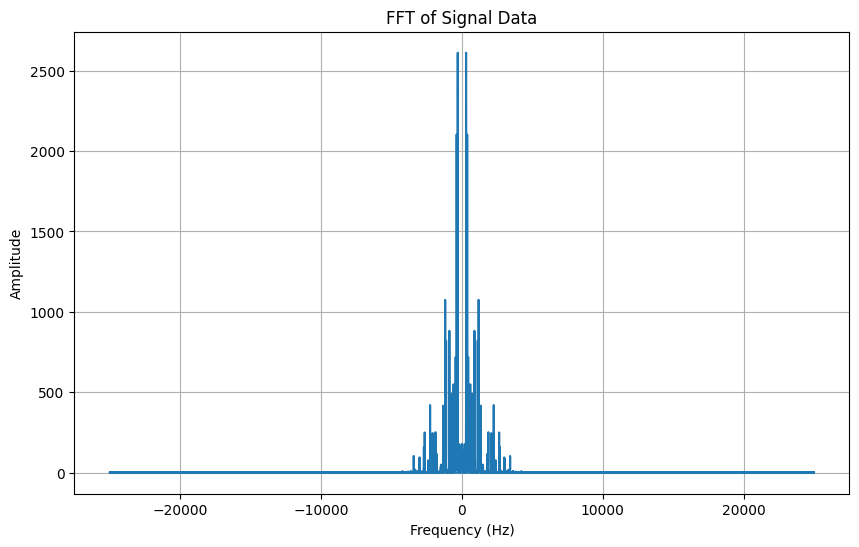

In [7]:
# Paso 4: Muestra la gráfica de la FFT
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, np.abs(fft_result)) #modificar para ver de [0:1000]
plt.title('FFT of Signal Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

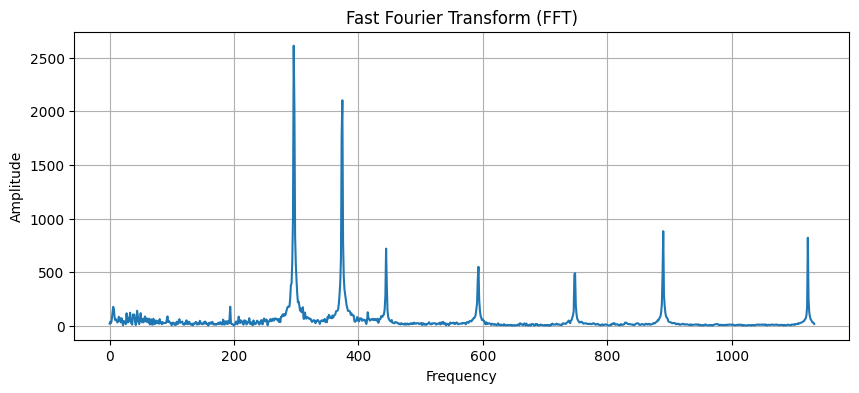

In [8]:
# Paso 5: Haz zoom y me muestras las primeras 1000 muestras
plt.figure(figsize=(10, 4))
plt.plot(fft_freq[0:1000], np.abs(fft_result[0:1000]))
plt.title('Fast Fourier Transform (FFT)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Algoritmo de la Transformada de Fourier Cuantica (QFT)

## Introducción

La QFT es la versión cuántica de la Transformada Discreta de Fourier (DFT) utilizada en la computación clásica, donde se aplica principalmente en teoría de señales para analizar el espectro y descomponer una señal en sus componentes de frecuencia.

En computacion clásica la DFT se define como una transformación que actua sobre un vector $(a_0, ..., a_{N-1})$ y lo transforma en otro vector $(\phi_0, ..., \phi_{N-1})$ por medio de los siguientes cálculos:


$$\phi_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_j\omega_N^{jk}$$

donde $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Nótese que los valores de $(a_0, ..., a_{N-1})$ son tipicamente una sucesión de valores reales y la DFT obtiene unos valores transformados $(\phi_0, ..., \phi_{N-1})$ que son números complejos.


En computacion cuántica la QFT se define como una transformacion de un estado cuántico $\vert \psi \rangle = \sum_{j=0}^{N-1} a_j \vert j \rangle$ que se transforma en otro estado cuántico $\vert \phi\rangle = \sum_{k=0}^{N-1} \phi_k \vert k \rangle$ por medio de los siguientes cálculos:


$$\phi_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_j\omega_N^{jk}$$


con $\omega_N^{jk}$ definida como anteriormente.


Y esto podemos expresarlo como sigue para un estado de la base:

$$\vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$

Es importante notar que esta transformación **modifica únicamente las amplitudes**, introduciendo fases en los coeficientes del estado cuántico.


Expresando la QFT en la forma de composicion de qubits unitarios tenemos que:

$$
QFT(\vert j_{n-1}...j_1j_0\rangle)= \frac{1}{\sqrt{N}}
(\vert 0 \rangle + e^{2 \pi i \frac{j_0}{2}} \vert 1 \rangle )\otimes
(\vert 0 \rangle + e^{2 \pi i (\frac{j_1}{2}+\frac{j_0}{2^2})} \vert 1 \rangle)\otimes ... \otimes
(\vert 0 \rangle + e^{2 \pi i (\frac{j_{n-1}}{2}+...+\frac{j_1}{2^{n-1}}+\frac{j_0}{2^n})} \vert 1 \rangle)$$




La formula anterior expresa la QFT para estados de $n$ qbits con $N=2^n$.

Cabe destacar que el último qubit depende de los valores de todos los qubits anteriores, mientras que cada qubit sucesivo depende de un menor número de qubits. Esto tiene importantes implicaciones en la implementación en hardware cuántico, ya que la conectividad entre qubits es limitada y puede afectar la eficiencia de la ejecución del circuito.

## Intuición

La QFT transforma un estado cuántico en la base Z a otro estado en la base X, funcionando como un cambio de base en el espacio de coordenadas de los vectores de estado:

$$
|\text{Estado en la base Z }\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{Estado en la base de Fourier}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

Los estados en la base de Fourier se denotan con (~)

## QFT para 4 qubits

La QFT para un sistema de 4 qubits se puede expresar en términos de la composición de operaciones unitarias de la siguiente manera:

$$
QFT(\vert j_{n-1}j_1...j_0\rangle)= \frac{1}{\sqrt{N}}
(\vert 0 \rangle + e^{2 \pi i \frac{j_0}{2}} \vert 1 \rangle )\otimes
(\vert 0 \rangle + e^{2 \pi i (\frac{j_0}{2^2}+\frac{j_1}{2})} \vert 1 \rangle)\otimes
(\vert 0 \rangle + e^{2 \pi i  (\frac{j_0}{2^3}+\frac{j_1}{2^{2}}+\frac{j_{2}}{2})}] \vert 1 \rangle)\otimes
(\vert 0 \rangle + e^{2 \pi i  (\frac{j_0}{2^4}+\frac{j_1}{2^{3}}+\frac{j_{2}}{2^2}+\frac{j_{3}}{2})}] \vert 1 \rangle)$$

### EJERCICIO 1

Implementa la QFT para 4 qbits

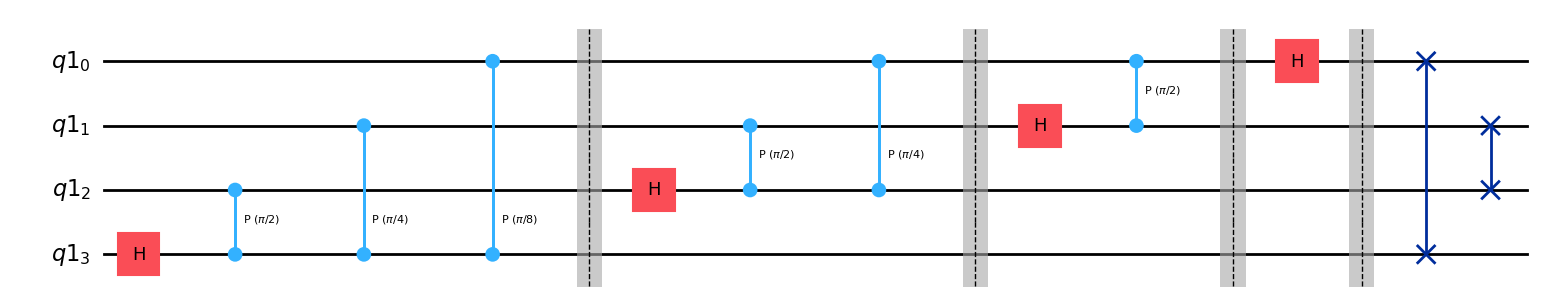

In [9]:
# Creo los 4 qubits
qreg = QuantumRegister(4)
 
qft = QuantumCircuit(qreg, name = 'QFT4qb') #Circuito de qft de 4 qubits

#Aplico las puertas necesarias para crear la QFT

#Aplico la puerta Hadamard al qubit 3, y luego las puertas de cambio de fase controladas a los qubits 2, 1 y 0
qft.h(qreg[3])
qft.cp(math.pi/2,qreg[2],qreg[3])
qft.cp(math.pi/4,qreg[1],qreg[3])
qft.cp(math.pi/8,qreg[0],qreg[3])
qft.barrier()


#Aplico la puerta Hadamard al qubit 2, y luego las puertas de cambio de fase controladas a los qubits 1 y 0
qft.h(qreg[2])
qft.cp(math.pi/2, qreg[1], qreg[2])
qft.cp(math.pi/4, qreg[0], qreg[2])
qft.barrier()

#Aplico la puerta Hadamard al qubit 1, y luego las puertas de cambio de fase controladas a los qubits 0
qft.h(qreg[1])
qft.cp(math.pi/2, qreg[0], qreg[1])
qft.barrier()

#Al final aplico una ultima Hadamard. 
qft.h(qreg[0])
qft.barrier()
#Agregamos los swaps
qft.swap(qreg[0], qreg[3])
qft.swap(qreg[1], qreg[2])


display(qft.draw('mpl'))

En este ejercicio creo el circuito de la QFT aplicando las puertas correspondientes uno a uno tal y como se explicó en la teoría de clase.
De la expresion de la QFT:
$$
QFT(\vert j_{n-1}j_1...j_0\rangle)= \frac{1}{\sqrt{N}}
(\vert 0 \rangle + e^{2 \pi i \frac{j_0}{2}} \vert 1 \rangle )\otimes
(\vert 0 \rangle + e^{2 \pi i (\frac{j_0}{2^2}+\frac{j_1}{2})} \vert 1 \rangle)\otimes
(\vert 0 \rangle + e^{2 \pi i  (\frac{j_0}{2^3}+\frac{j_1}{2^{2}}+\frac{j_{2}}{2})}] \vert 1 \rangle)\otimes
(\vert 0 \rangle + e^{2 \pi i  (\frac{j_0}{2^4}+\frac{j_1}{2^{3}}+\frac{j_{2}}{2^2}+\frac{j_{3}}{2})}] \vert 1 \rangle)$$

Se puede simplicar la ecuacion en lo siguiente para n qubits:
$$
QFT(\vert x\rangle)= \frac{1}{\sqrt{N}}
(\vert 0 \rangle + e^{2 \pi i \frac{x}{2}} \vert 1 \rangle )\otimes
(\vert 0 \rangle + e^{2 \pi i \frac{x}{2^2}} \vert 1 \rangle)
\otimes ... \otimes
(\vert 0 \rangle + e^{2 \pi i  \frac{x}{2^n-1}}] \vert 1 \rangle)\otimes
(\vert 0 \rangle + e^{2 \pi i  \frac{x}{2^n}}] \vert 1 \rangle)$$

Como hemos visto en teoría, todo esto se traduce a simplemente rotaciones de fase $R_\phi$ y puertas $H$

Tenemos que ir aplicando a cada qubit $i$ lo siguiente:
- Primero una puerta $H$ al qubit i.
- Luego seguidamente aplicar i puertas $CR_{\pi/2^k}$ puertas de rotacion de fase controlada, tomando como qubit objetivo el qubit i.
- Empezando por el qubit $i - 1$ hasta el qubit 0.
- Tomamos como control el qubit $i - k$ donde $i-k >= 0$ y la rotacion que aplicamos es de ${\pi/2^k}$.
- Por último aplico los Swaps, el qubit $i$ por $n - i$

Se puede ver en el código del circuito. 


#### EJERCICIO 2

Calcula la QFT para un número de bits genérico n, de forma iterativa con un bucle `FOR`para poner las puertas que corresponden a cada qubit y los `SWAP`s

In [10]:
def qft_n_qubits(circuit, n):
    
    for i in range(n - 1, -1, -1): #Empezamos por el mas significativo
        circuit.h(circuit.qubits[i])
        for j in range(i - 1, -1, -1):
            circuit.cp(math.pi/2**(i - j), circuit.qubits[j], circuit.qubits[i])
        
        circuit.barrier()
        
    #Al final del todo agregamos los Swaps 
    for i in range(n//2):
        circuit.swap(circuit.qubits[i], circuit.qubits[n - 1 - i])
    
    return circuit


Aqui creo una funcion donde creo una QFT para un circuito de n qubits. 
La funcion $qft\_n\_qubits(circuit, n)$ recibe ya un circuito $circuit$ de n qubits.

El primer bucle es para recorrer los n qubits y aplicar las rotaciones que he explicado en el ejercicio anterior.
- Empiezo por el qubit más significativo hasta el qubit 0 como se ve con el bucle $for\ i\ in\ range(n - 1, -1, -1):$.
- Aplico una $Hadamard$ con $circuit.h(circuit.qubits[i])$. 
- Luego itero desde $i - 1$ hasta 0 aplicando las rotaciones de fase con el bucle $for\ j\ in\ range(i - 1, -1, -1):$.
- Ya al final aplico los Swaps con otro bucle que itera desde el qubit $0$ hasta $\lfloor n/2 \rfloor$. Los aplico sobre $i$ y $n - i$

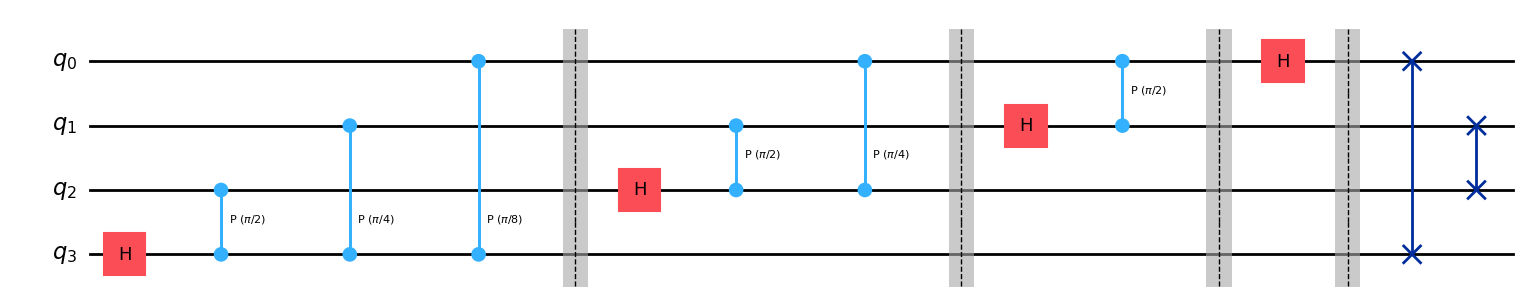

In [11]:
cPrueba = qft_n_qubits(QuantumCircuit(4), 4)

display(cPrueba.draw('mpl'))

## Circuito general de la QFT
El circuito que implementa la Transformada Cuántica de Fourier (QFT) para cualquier cantidad de qubits, se puede observar en el siguiente código. En este caso, se utiliza un enfoque recursivo para construir de manera eficiente los conjuntos de puertas correspondientes a cada qubit.

#### QFT Recursivo intuitivo

In [ ]:
def qft_aux(circuito, i):
    
    if (i == 0): #Caso base
        circuito.h(circuito.qubits[0])
    else: #Caso recursivo
        circuito.h(circuito.qubits[i])
        
        #for j in range(i - 1, -1, -1):
            #circuito.cp(math.pi/2**(i - j), circuito.qubits[j], circuito.qubits[i])
        #circuito.barrier()
        
        for j in range(i):
            circuito.cp(math.pi/2**(i - j), circuito.qubits[j], circuito.qubits[i])
        
        circuito = qft_aux(circuito, i - 1)
        
    return circuito
    
def qft_recursivo(circuit, n):
    #Asumo que recibo un circuito ya con los qubits 
    
    circuit = qft_aux(circuit, n - 1)
    
    #Al final del todo agregamos los Swaps 
    for i in range(n//2):
        circuit.swap(circuit.qubits[i], circuit.qubits[n - 1 - i])
    
    return circuit

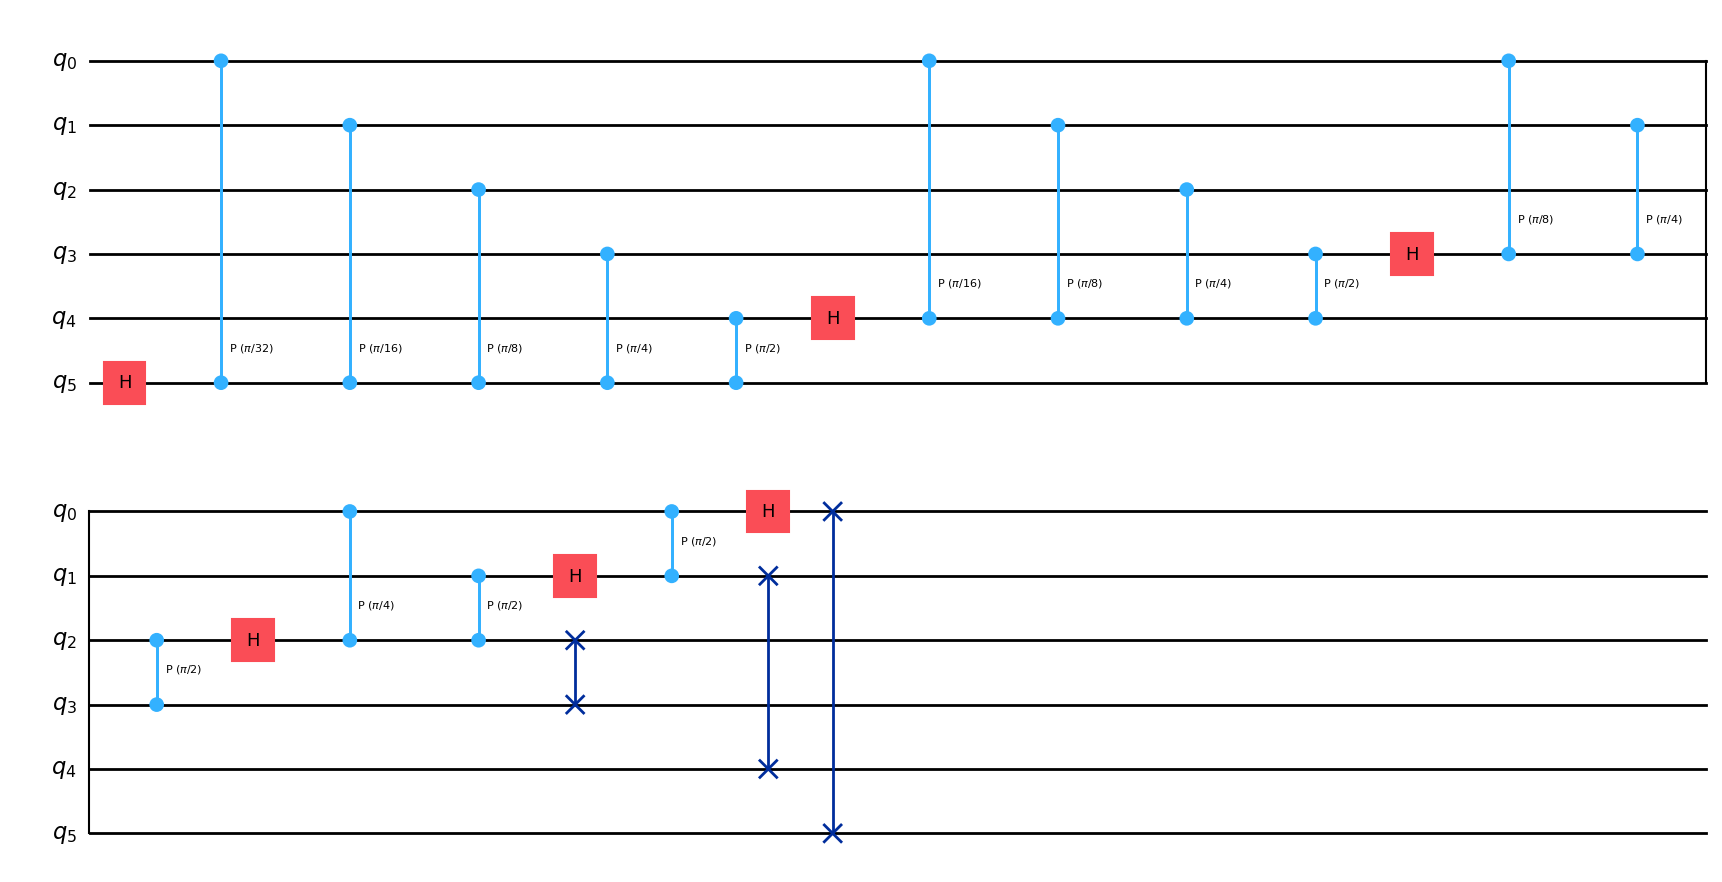

In [21]:
crecursivo = qft_recursivo(QuantumCircuit(6), 6)

display(crecursivo.draw('mpl'))

Aquí creo una función $qft\_recursivo(circuito,n)$ que calcula la QFT de un circuito con $n$ qubits.\
$qft\_recursivo(circuito,n)$ es la función principal, que luego llama a otra llamada $qft\_aux(circuito, i)$ que es la encargada de hacer la recursión.\
En la función principal llamamos a qft_aux(circuito, n - 1) y después de que este haga sus cálculos coloco los $SWAPS$ al igual que en la implementacion con bucle $for$.\
La función recursiva recibe el circuito y un $i$ que indica qué qubit estamos tratando:
- Caso Base (si i == 0): estamos en el último qubit por lo que solo colocamos una Hadamard.
- Caso recursivo (i > 0): estamos en un qubit intermedio.\
Para este caso coloco primero una Hadamard y luego las puertas $Controled\_Phase\_Gates$ mediante un bucle $for$ empezando por el qubit menos significativo hasta i - 1. Tomo el qubit i como objetivo y luego &k < i& serán los objetivo. Voy aplicando $CP_\frac{\pi}{2^k}$.\
Una vez colocado las puertas para $i$ paso a colocar las de i - 1 con la llamada $qft\_aux(circuito, i - 1)$


## Creando estados cuánticos periódicos

Se construyen tres circuitos cuánticos de 4 qubits, cada uno diseñado para generar un estado cuántico con distinta periodicidad en la fase del registro cuántico

In [31]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile, assemble
import numpy as np

def crear_señal(which_signal):
    #creamos un registro cuántico donde almacenaremos una señal periódica A, B o C
    #codificamos esa periodicidad en la fase de los qbits del registro
    signal = QuantumRegister(4, name='signal')
    qc = QuantumCircuit(signal)

    ## preparamos las señales
    qc.h(signal)
    if which_signal == 'A':
        qc.rz(math.radians(180), signal[0])
    elif which_signal == 'B':
        qc.rz(math.radians(-90), signal[0])
        qc.rz(math.radians(180), signal[1])
    elif which_signal == 'C':
        qc.rz(math.radians(-45), signal[0])
        qc.rz(math.radians(-90), signal[1])
        qc.rz(math.radians(180), signal[2])

    qc.barrier()
    return qc
#display(qc.draw(output='mpl'))  # Visualizar con Matplotlib

In [32]:
#Probar con señal A (se repite 8 veces, señal B se repite 4, señal C se repite 2 veces
qc=crear_señal('A')
qc.draw()

backend = Aer.get_backend('statevector_simulator')
job = backend.run(qc)
result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
display(array_to_latex(outputstate))

for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

<IPython.core.display.Latex object>

|0> -0.25j probabilidad = 6.25%
|1> 0.25j probabilidad = 6.25%
|2> -0.25j probabilidad = 6.25%
|3> 0.25j probabilidad = 6.25%
|4> -0.25j probabilidad = 6.25%
|5> 0.25j probabilidad = 6.25%
|6> -0.25j probabilidad = 6.25%
|7> 0.25j probabilidad = 6.25%
|8> -0.25j probabilidad = 6.25%
|9> 0.25j probabilidad = 6.25%
|10> -0.25j probabilidad = 6.25%
|11> 0.25j probabilidad = 6.25%
|12> -0.25j probabilidad = 6.25%
|13> 0.25j probabilidad = 6.25%
|14> -0.25j probabilidad = 6.25%
|15> 0.25j probabilidad = 6.25%


##Aplicación de la QFT para determinar la frecuencia de repetición de un estado cuántico

### EJERCICIO 3

Utiliza la QFT y calcula el periodo de los tres estados cuánticos creados en el apartado anterior

┌───┐┌───────┐ ░ 
signal_0: ┤ H ├┤ Rz(π) ├─░─
          ├───┤└───────┘ ░ 
signal_1: ┤ H ├──────────░─
          ├───┤          ░ 
signal_2: ┤ H ├──────────░─
          ├───┤          ░ 
signal_3: ┤ H ├──────────░─
          └───┘          ░

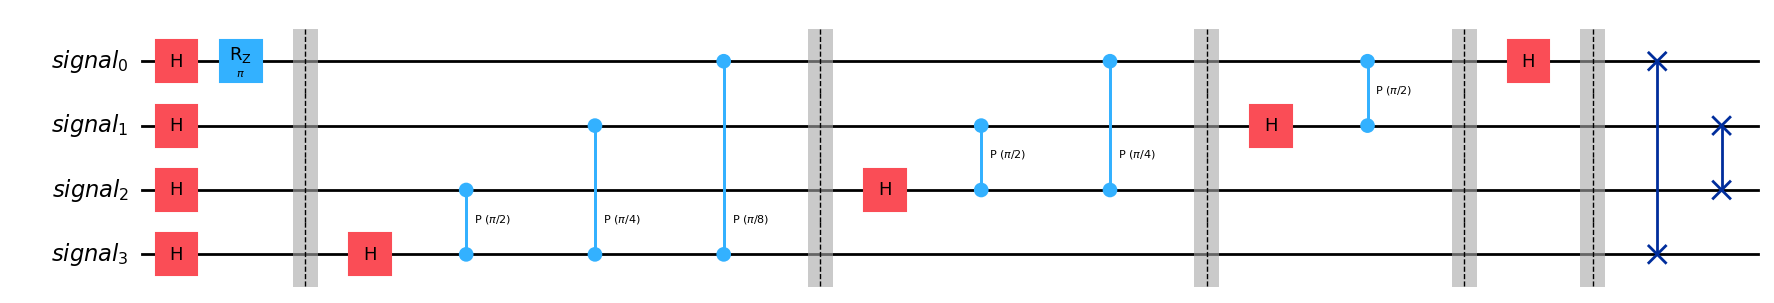

|8> (-0-1j) probabilidad = 100.0%


In [91]:
#Aqui pruebo la señal A

qcA = crear_señal('A')
display(qcA.draw())

#Calculo la QFT del cicuito con la señal A
qft_n_qubits(qcA, 4)

display(qcA.draw('mpl'))


backend = Aer.get_backend('statevector_simulator')
job = backend.run(qcA)
result = job.result()

outputstate = result.get_statevector(qcA, decimals=3)

for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))


En este caso he creado la señal A usando la llamada a $crear\_señal('A')$. \
Tras aplicar la $QFT_4qubits$ obtengo un $100.00\%$ de probabilidad de obtener el $\ket{8}$ que coincide con la periodicidad de la señal A. \
Para aplicar la QFT he usado la funcion que he implementado previamente en el Notebook $qft\_n\_qubits(qcA, 4)$. \
La funcion lo había implementado para que dado un circuito, directamente agrege las puertas de la QFT a continuacion de lo que tenga ya el circuito.

┌───┐┌──────────┐ ░ 
signal_0: ┤ H ├┤ Rz(-π/2) ├─░─
          ├───┤└┬───────┬─┘ ░ 
signal_1: ┤ H ├─┤ Rz(π) ├───░─
          ├───┤ └───────┘   ░ 
signal_2: ┤ H ├─────────────░─
          ├───┤             ░ 
signal_3: ┤ H ├─────────────░─
          └───┘             ░

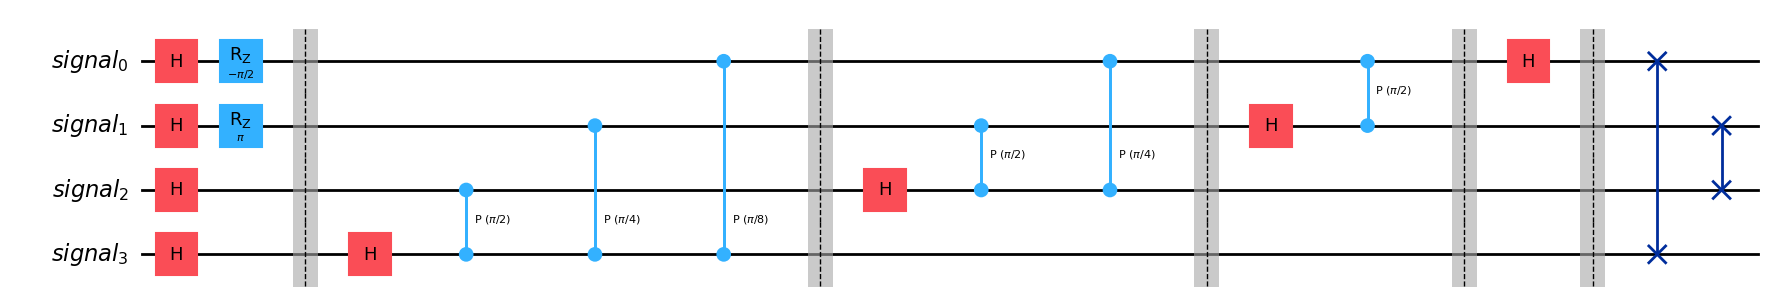

|4> (0.707-0.707j) probabilidad = 99.9698%


In [92]:
#Aqui pruebo la señal B

qcB = crear_señal('B')
display(qcB.draw())

qft_n_qubits(qcB, 4)



display(qcB.draw('mpl'))


backend = Aer.get_backend('statevector_simulator')
job = backend.run(qcB)
result = job.result()

outputstate = result.get_statevector(qcB, decimals=3)


for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

┌───┐┌──────────┐ ░ 
signal_0: ┤ H ├┤ Rz(-π/4) ├─░─
          ├───┤├──────────┤ ░ 
signal_1: ┤ H ├┤ Rz(-π/2) ├─░─
          ├───┤└┬───────┬─┘ ░ 
signal_2: ┤ H ├─┤ Rz(π) ├───░─
          ├───┤ └───────┘   ░ 
signal_3: ┤ H ├─────────────░─
          └───┘             ░

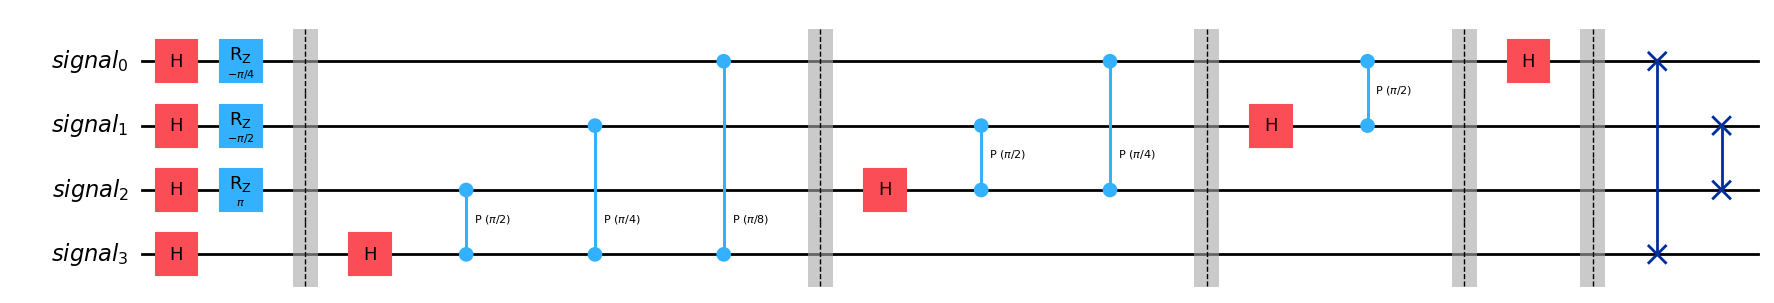

|2> (0.924-0.383j) probabilidad = 100.0465%


In [ ]:
#Aqui pruebo la señal C

qcC = crear_señal('C')
display(qcC.draw())

qft_n_qubits(qcC, 4)


display(qcC.draw('mpl'))


backend = Aer.get_backend('statevector_simulator')
job = backend.run(qcC)
result = job.result()

outputstate = result.get_statevector(qcC, decimals=3)


for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

Tras hacer más pruebas con la señal C y B, obtengo en ambos casos la periodicidad correcta.

- Para la señal B obtengo un $99.9698\%$ de probabilidad de obtener $\ket{4}$.
- Para la señal C obtengo un $100.0465\%$ de probabilidad de obtener $\ket{2}$.

El procedimiento que he usado ha sido el mismo que para la señal A

## La QFT inversa

La transformada de Fourier inversa nos permite generar un estado cuántico con un patrón específico de periodicidades o frecuencias en sus amplitudes.

Podemos implementarla de una forma sencilla con el metodo ```.inverse()``` de la clase ```QuantumCircuit```

In [95]:
def inverse_qft(circuit, n):
    """Funcion que implementa la QFT inversa para los n primeros bits de un circuito cuantico"""
    # Creamos el circuito de n bits
    qft_circ = qft_n_qubits(QuantumCircuit(n), n)
    # Calculamos el circuito inverso
    invqft_circ = qft_circ.inverse()
    # lo añadimos al circuito creado
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit

He modificado la funcion para aplicar la QFT por el nombre de la funcion que tengo yo

In [96]:
qc = QuantumCircuit(4)
inverse_qft(qc,4)
qc.decompose().draw()   # .decompose() para verlo con puertas individuales

░ ┌───┐ ░                 ░                           ░           »
q_0: ────X──░─┤ H ├─░──■──────────────░──■────────────────────────░──■────────»
         │  ░ └───┘ ░  │P(-π/2) ┌───┐ ░  │                        ░  │        »
q_1: ─X──┼──░───────░──■────────┤ H ├─░──┼─────────■──────────────░──┼────────»
      │  │  ░       ░           └───┘ ░  │P(-π/4)  │P(-π/2) ┌───┐ ░  │        »
q_2: ─X──┼──░───────░─────────────────░──■─────────■────────┤ H ├─░──┼────────»
         │  ░       ░                 ░                     └───┘ ░  │P(-π/8) »
q_3: ────X──░───────░─────────────────░───────────────────────────░──■────────»
            ░       ░                 ░                           ░           »
«                              
«q_0: ─────────────────────────
«                              
«q_1: ─■───────────────────────
«      │                       
«q_2: ─┼─────────■─────────────
«      │P(-π/4)  │P(-π/2) ┌───┐
«q_3: ─■─────────■────────┤ H ├
«                         └───┘

In [86]:
#De una frecuencia obtener un estado con esa frecuencia

#Preparamos el circuito
qc = QuantumCircuit(4)

#Ppreparamos la frecuencia |2> = |0010>  con la notacion |q3q2q1q0>
qc.x(1)
qc.barrier()

inverse_qft(qc,4)
display(qc.decompose().draw())

backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend = backend, optimization_level= 1)  #opcional

job = backend.run(qc)
result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))


░        ░ ┌───┐ ░                 ░                     »
q_0: ──────────────░──X─────░─┤ H ├─░──■──────────────░──■──────────────────»
     ┌───────────┐ ░  │     ░ └───┘ ░  │P(-π/2) ┌───┐ ░  │                  »
q_1: ┤ U3(π,0,π) ├─░──┼──X──░───────░──■────────┤ H ├─░──┼─────────■────────»
     └───────────┘ ░  │  │  ░       ░           └───┘ ░  │P(-π/4)  │P(-π/2) »
q_2: ──────────────░──┼──X──░───────░─────────────────░──■─────────■────────»
                   ░  │     ░       ░                 ░                     »
q_3: ──────────────░──X─────░───────░─────────────────░─────────────────────»
                   ░        ░       ░                 ░                     »
«           ░                                    
«q_0: ──────░──■─────────────────────────────────
«           ░  │                                 
«q_1: ──────░──┼─────────■───────────────────────
«     ┌───┐ ░  │         │                       
«q_2: ┤ H ├─░──┼─────────┼─────────■─────────────
«     └───┘ ░  │P(-π/8)  │P(-π/4)  │P(-π/2) ┌───┐
«q_3: ──────░──■─────────■─────────■────────┤ H ├
«           ░                               └───┘

|0> (0.25-0j) probability = 6.25%
|1> (0.177-0.177j) probability = 6.2658%
|2> (-0-0.25j) probability = 6.25%
|3> (-0.177-0.177j) probability = 6.2658%
|4> (-0.25+0j) probability = 6.25%
|5> (-0.177+0.177j) probability = 6.2658%
|6> 0.25j probability = 6.25%
|7> (0.177+0.177j) probability = 6.2658%
|8> (0.25-0j) probability = 6.25%
|9> (0.177-0.177j) probability = 6.2658%
|10> (-0-0.25j) probability = 6.25%
|11> (-0.177-0.177j) probability = 6.2658%
|12> (-0.25+0j) probability = 6.25%
|13> (-0.177+0.177j) probability = 6.2658%
|14> 0.25j probability = 6.25%
|15> (0.177+0.177j) probability = 6.2658%


### EJERCICIO 4
 
Calcula la QFT de la QFT inversa del ejercicio anterior y verifica que la frecuencia resultante coincide con la inicial

In [104]:
#De una frecuencia obtener un estado con esa frecuencia

#Preparamos el circuito
qc = QuantumCircuit(4)

#Ppreparamos la frecuencia |2> = |0010>  con la notacion |q3q2q1q0>
qc.x(1)
qc.barrier()


#Calculamos la QFT inversa del circuito
inverse_qft(qc,4)
display(qc.decompose().draw())



####CALCULAMOS LA QFT DEL CIRCUITO
qc.barrier()

qft_n_qubits(qc, 4) #Aplico la QFT al circuito con la funcion que he definido mas arriba 

display(qc.draw())

###EJECUCION EN SIMULADOR

backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend = backend, optimization_level= 1)  #opcional

job = backend.run(qc)
result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))

#visualizamos el output_state


░        ░ ┌───┐ ░                 ░                     »
q_0: ──────────────░──X─────░─┤ H ├─░──■──────────────░──■──────────────────»
     ┌───────────┐ ░  │     ░ └───┘ ░  │P(-π/2) ┌───┐ ░  │                  »
q_1: ┤ U3(π,0,π) ├─░──┼──X──░───────░──■────────┤ H ├─░──┼─────────■────────»
     └───────────┘ ░  │  │  ░       ░           └───┘ ░  │P(-π/4)  │P(-π/2) »
q_2: ──────────────░──┼──X──░───────░─────────────────░──■─────────■────────»
                   ░  │     ░       ░                 ░                     »
q_3: ──────────────░──X─────░───────░─────────────────░─────────────────────»
                   ░        ░       ░                 ░                     »
«           ░                                    
«q_0: ──────░──■─────────────────────────────────
«           ░  │                                 
«q_1: ──────░──┼─────────■───────────────────────
«     ┌───┐ ░  │         │                       
«q_2: ┤ H ├─░──┼─────────┼─────────■─────────────
«     └───┘ ░  │P(-π/8)  │P(-π/4)  │P(-π/2) ┌───┐
«q_3: ──────░──■─────────■─────────■────────┤ H ├
«           ░                               └───┘

░ ┌─────────────────┐ ░                                  ░      »
q_0: ──────░─┤0                ├─░─────────────────────────■────────░──────»
     ┌───┐ ░ │                 │ ░                         │        ░      »
q_1: ┤ X ├─░─┤1                ├─░────────────────■────────┼────────░──────»
     └───┘ ░ │  circuit-375_dg │ ░                │        │        ░ ┌───┐»
q_2: ──────░─┤2                ├─░───────■────────┼────────┼────────░─┤ H ├»
           ░ │                 │ ░ ┌───┐ │P(π/2)  │P(π/4)  │P(π/8)  ░ └───┘»
q_3: ──────░─┤3                ├─░─┤ H ├─■────────■────────■────────░──────»
           ░ └─────────────────┘ ░ └───┘                            ░      »
«                        ░                ░ ┌───┐ ░       
«q_0: ──────────■────────░───────■────────░─┤ H ├─░──X────
«               │        ░ ┌───┐ │P(π/2)  ░ └───┘ ░  │    
«q_1: ─■────────┼────────░─┤ H ├─■────────░───────░──┼──X─
«      │P(π/2)  │P(π/4)  ░ └───┘          ░       ░  │  │ 
«q_2: ─■────────■────────░────────────────░───────░──┼──X─
«                        ░                ░       ░  │    
«q_3: ───────────────────░────────────────░───────░──X────
«                        ░                ░       ░

|2> (1-0j) probability = 100.0%


En este ejercicio se nos pide aplicar primero la QFT inversa a un estado que codifica una frecuencia para obtener un estado con la periodicidad de la fase indicada en el estado original. Para ver que el circuito se ha aplicado correctamente, vuelvo a aplicar una QFT sobre la inversa y así obtener la frecuencia original. \
La frecuencia que codifico al inicio es: $\ket{2}$ o $\ket{0010}$ aplicando simplemente una puerta $X$ al segundo qubit menos significativo.

Para empezar aplico la QFT inversa al circuito: $inverse\_qft(qc,4)$.\
Muestro el circuito y en la primera imagen se ve la QFT inversa usando la funcion .decompose(). Se puede ver que se implemente como simplemente aplicando de vuelta las mismas puertas que la QFT en orden inverso y deshaciendo las rotaciones de fase. Es decir, si se ha aplicado en la QFT una rotacion de $R_\phi$ en la QFT inversa se aplica $R_{-\phi}$.

A continuacion le inserto las puertas de la QFT usando la funcion que he implementado en el ejericio 2.\
Lo muestro también, pero esta vez sin decompose() pues me descompondría las puertas de la QFT. La QFT inversa pasa a ser $circuit-375\_dg $ en esta segunda imagen.

Lo simulo y obtengo un $100.0\%$ de probabilidad de obtener la frecuencia inicial que he codificado.


## Ejecución en un Simulador con ruido

### EJERCICIO 5

Crear una señal, calcular su QFT y ejecutarla en un simulador con y sin ruido

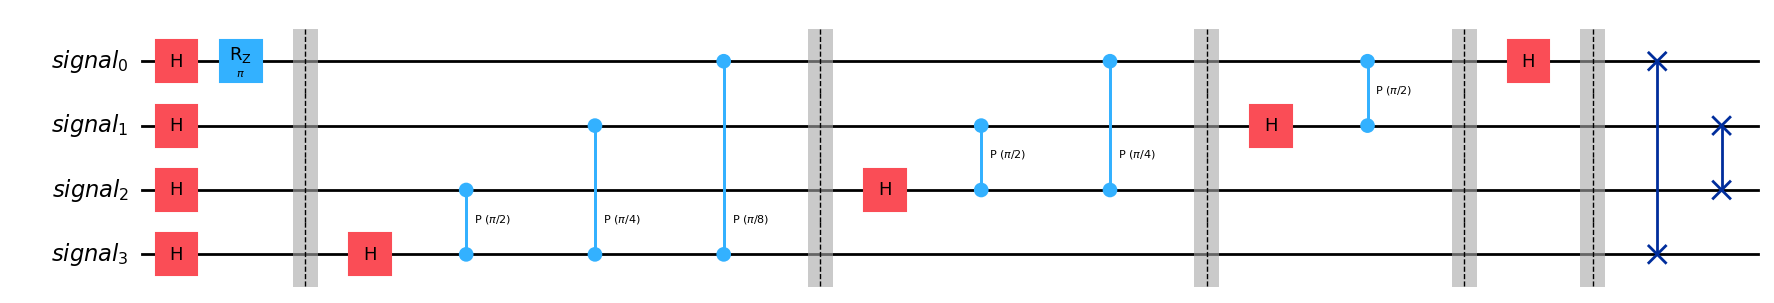

|8> (-0-1j) probability = 100.0%


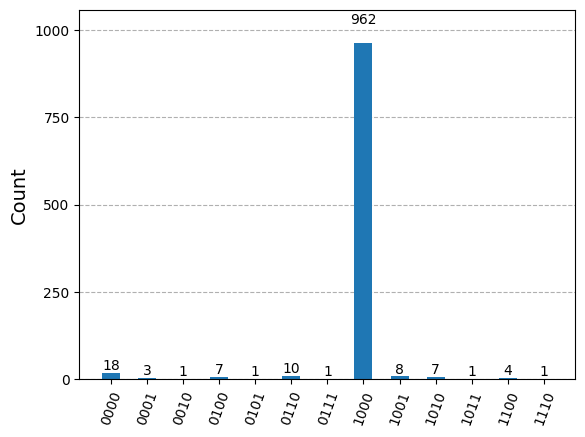

In [ ]:
##crear el circuito con una señal y calcular su QFT
#Aqui lo pruebo con la señal A
s='A' #señal
n= 4 #qubits

#Lo pruebo con la señal C
circuito = crear_señal(s)
qft_n_qubits(circuito, n)

display(circuito.draw('mpl'))

##SIN RUIDO
##crea el simulador

backend = Aer.get_backend('statevector_simulator')


# Transpilamos el circuito para mapearlo a las puertas ruidosas
circ_tranpilado1 = transpile(circuito, backend = backend, optimization_level= 1)  #opcional

# Ejecutamos el circuito y obtenemos el resultado
job = backend.run(circ_tranpilado1)
result = job.result()

outputstate = result.get_statevector(circ_tranpilado1, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))



#Añadimos medidas al circuito
circuito.measure_all()
#display(circuito.draw('mpl'))

##CON RUIDO
# Tomamos un backend ruidoso ficticio de fake providers y creamos el simulador
backend = GenericBackendV2(num_qubits = 4)
# Transpilamos el circuito para mapearlo a las puertas ruidosas
circ_transpilado2 = transpile(circuito, backend = backend)
# Ejecutamos el circuito y obtenemos el resultado
job = backend.run(circ_transpilado2)
result = job.result()

counts = result.get_counts()
plot_histogram(counts)

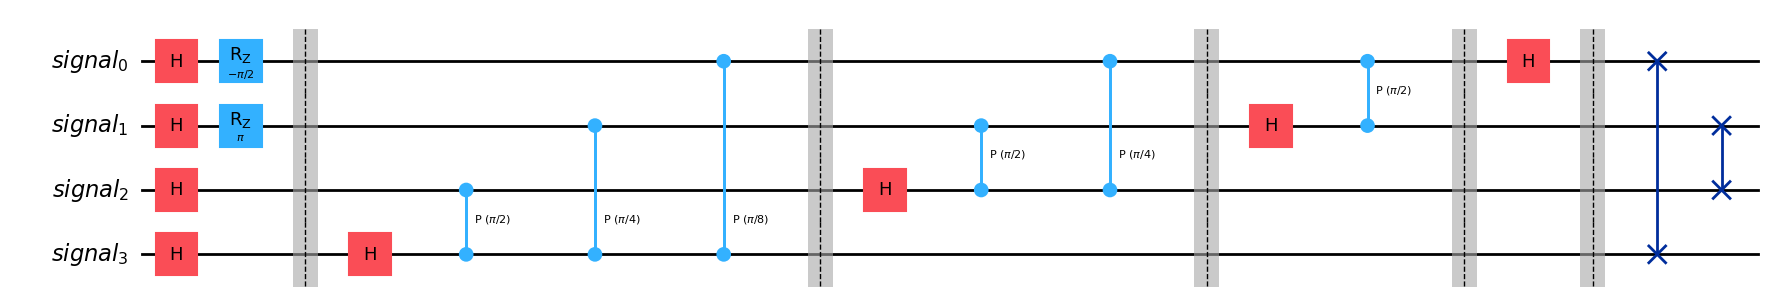

|4> (0.707-0.707j) probability = 99.9698%


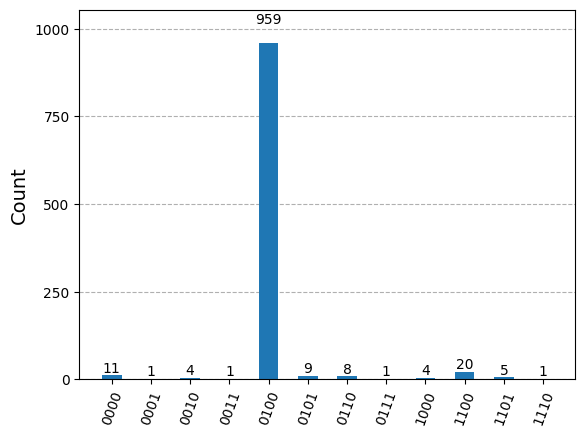

In [120]:
##crear el circuito con una señal y calcular su QFT
#Aqui lo pruebo con la señal B
s='B' #señal
n= 4 #qubits

#Lo pruebo con la señal C
circuito = crear_señal(s)
qft_n_qubits(circuito, n)

display(circuito.draw('mpl'))

##SIN RUIDO
##crea el simulador

backend = Aer.get_backend('statevector_simulator')


# Transpilamos el circuito para mapearlo a las puertas ruidosas
circ_tranpilado1 = transpile(circuito, backend = backend, optimization_level= 1)  #opcional

# Ejecutamos el circuito y obtenemos el resultado
job = backend.run(circ_tranpilado1)
result = job.result()

outputstate = result.get_statevector(circ_tranpilado1, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))



#Añadimos medidas al circuito
circuito.measure_all()
#display(circuito.draw('mpl'))

##CON RUIDO
# Tomamos un backend ruidoso ficticio de fake providers y creamos el simulador
backend = GenericBackendV2(num_qubits = 4)
# Transpilamos el circuito para mapearlo a las puertas ruidosas
circ_transpilado2 = transpile(circuito, backend = backend)
# Ejecutamos el circuito y obtenemos el resultado
job = backend.run(circ_transpilado2)
result = job.result()

counts = result.get_counts()
plot_histogram(counts)

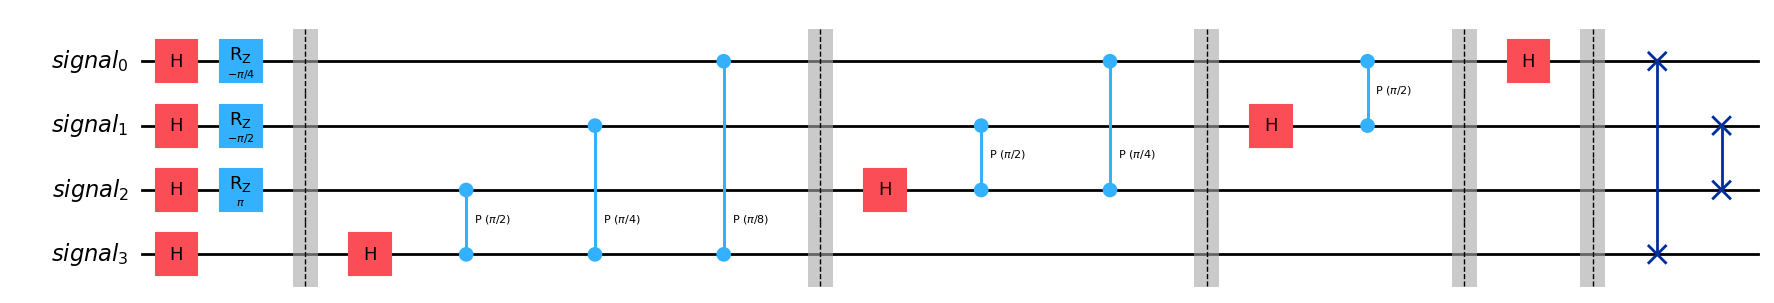

|2> (0.924-0.383j) probability = 100.0465%


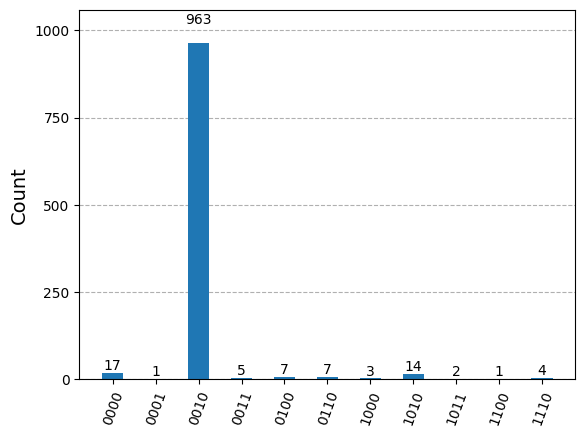

In [ ]:
##crear el circuito con una señal y calcular su QFT
#Aqui lo pruebo con la señal C
s='C' #señal
n= 4 #qubits

#Lo pruebo con la señal C
circuito = crear_señal(s)
qft_n_qubits(circuito, n)

display(circuito.draw('mpl'))

##SIN RUIDO
##crea el simulador

backend = Aer.get_backend('statevector_simulator')


# Transpilamos el circuito para mapearlo a las puertas ruidosas
circ_tranpilado1 = transpile(circuito, backend = backend, optimization_level= 1)  #opcional

# Ejecutamos el circuito y obtenemos el resultado
job = backend.run(circ_tranpilado1)
result = job.result()

outputstate = result.get_statevector(circ_tranpilado1, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))



#Añadimos medidas al circuito
circuito.measure_all()
#display(circuito.draw('mpl'))

##CON RUIDO
# Tomamos un backend ruidoso ficticio de fake providers y creamos el simulador
backend = GenericBackendV2(num_qubits = 4)
# Transpilamos el circuito para mapearlo a las puertas ruidosas
circ_transpilado2 = transpile(circuito, backend = backend)
# Ejecutamos el circuito y obtenemos el resultado
job = backend.run(circ_transpilado2)
result = job.result()

counts = result.get_counts()
plot_histogram(counts)



En este ejercicio se nos pide simular los circuitos con simuladores con ruido.\
El simulador con ruido que he usado es el de la librería de $qiskit.providers.fake_providers$.\
Creo el backend mediante el constructor $backend\ =\ GenericBackendV2(num\_qubits\ =\ 4)$.\
Transpilo el circuito y realizo la ejecuto el circuito. El circuito se ejecuta como $"qasm\_simulator"$ de Aer que obtenemos el conteo de resultados en la medición.\
Por eso al final del circuito he añadido la medición de los qubits: $measure\_all()$.

Viendo los histogramas podemos ver que los estados dominantes al medir (1000 shots por defecto) son las correspondientes a cada tipo de señal:
- Señal tipo A: 962.
- Señal tipo B: 959.
- Señal tipo C: 963.

También vemos que hay mediciones incorrectos ya que estamos usando simuladores con ruido.

## Ejecución en HW cuantico real

### EJERCICIO 6

Crear una señal, calcular su QFT y ejecutarla en un dispositivo cuántico real

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

token = "" #Para la entrega he borrado el token

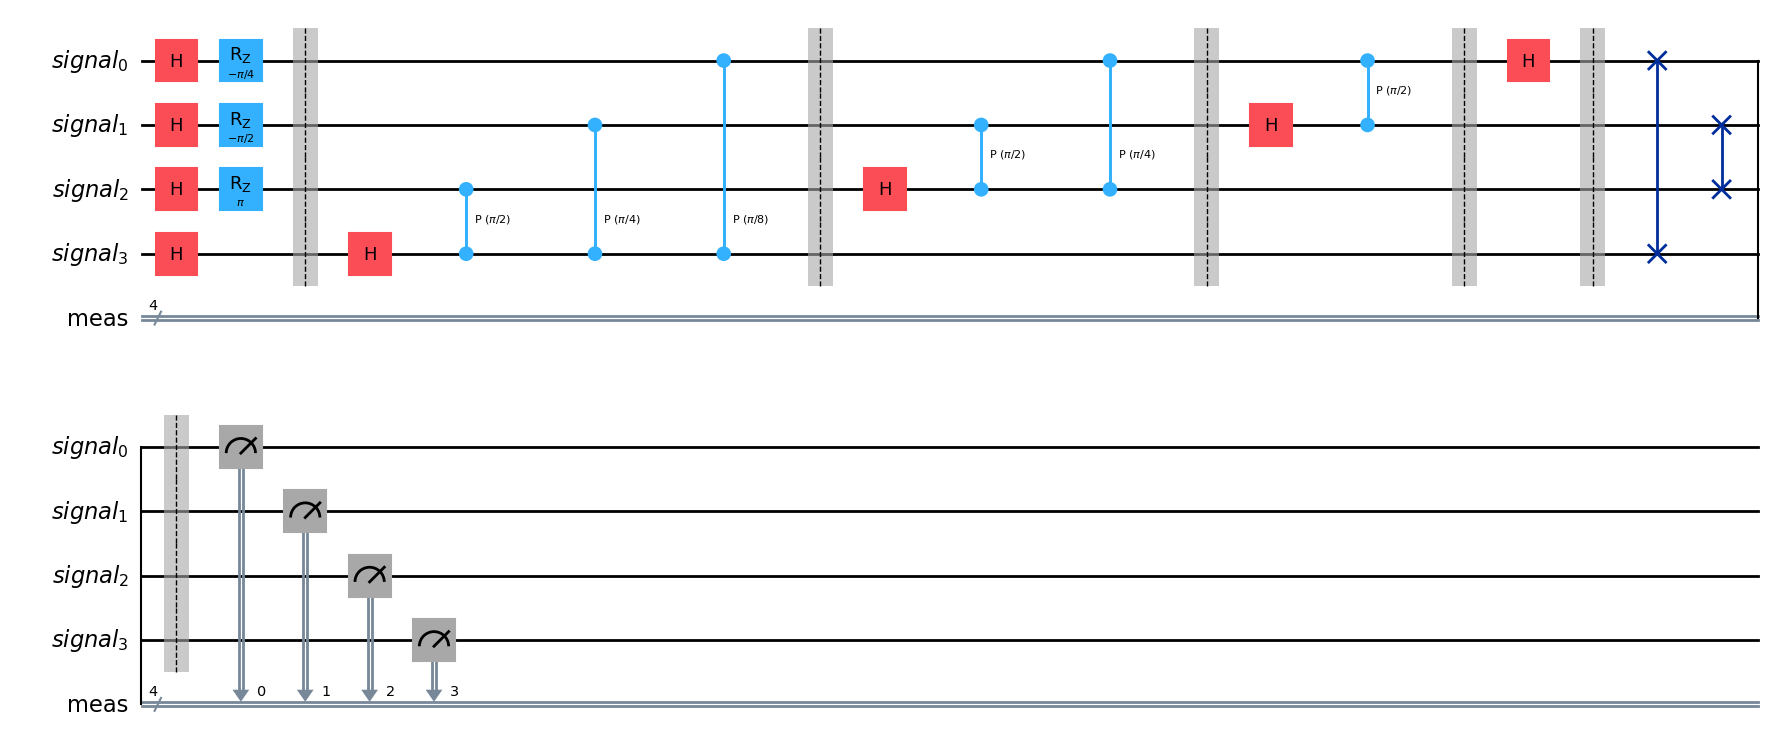

In [ ]:
#Pruebo con la señal C
s='C' #señal
n= 4 #qubits

#Creo el circuito con la señal C
circuito = crear_señal(s)
qft_n_qubits(circuito, n)

circuito.measure_all()

display(circuito.draw('mpl'))

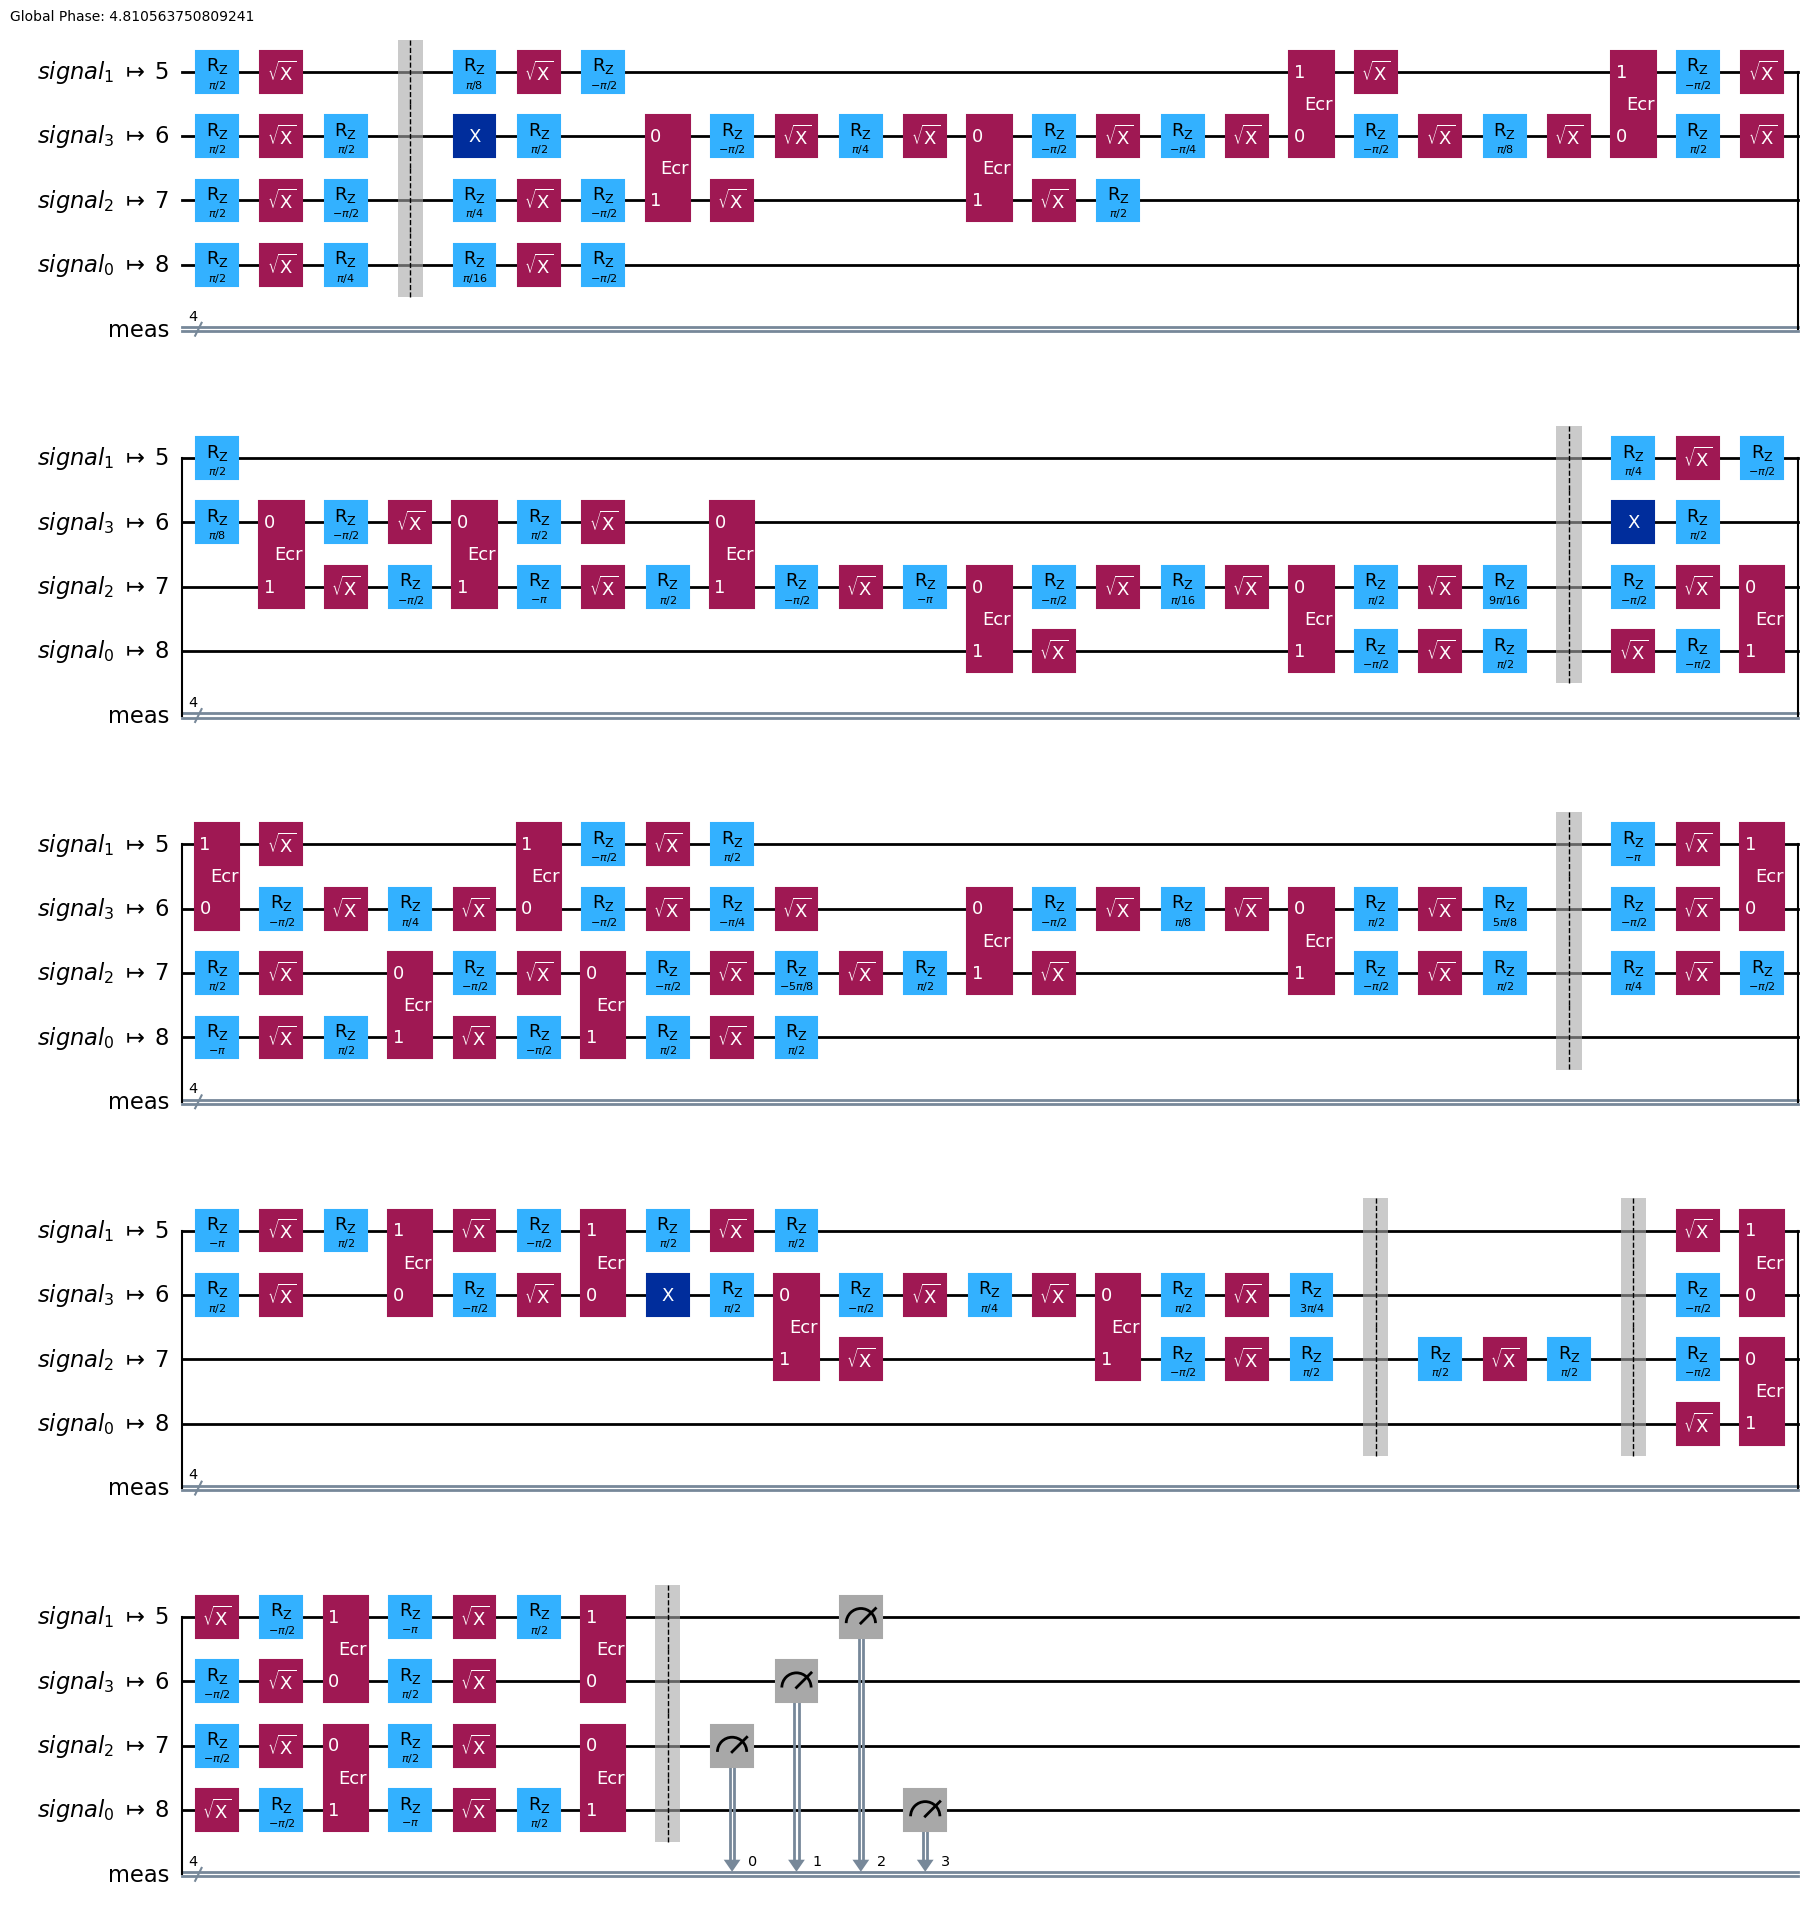

In [131]:

service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuito)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)


In [140]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=1000)
print(f"job id: {job.job_id()}")
result = job.result()

job id: czg4wnj7m0r0008vvx0g


Una vez ejecutado el job recuperamos los resultados de la ejecucion y visualizamos los resultados

{'0011': 15, '1010': 344, '1011': 26, '0010': 361, '1110': 58, '1100': 86, '0100': 22, '0000': 35, '1000': 15, '1101': 4, '0101': 7, '1001': 4, '1111': 5, '0110': 12, '0001': 2, '0111': 4}


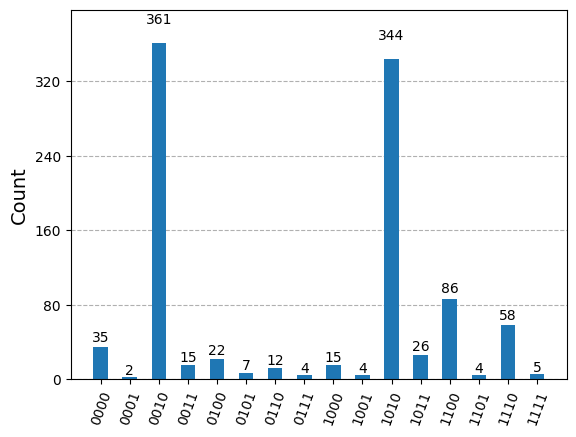

In [141]:
#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

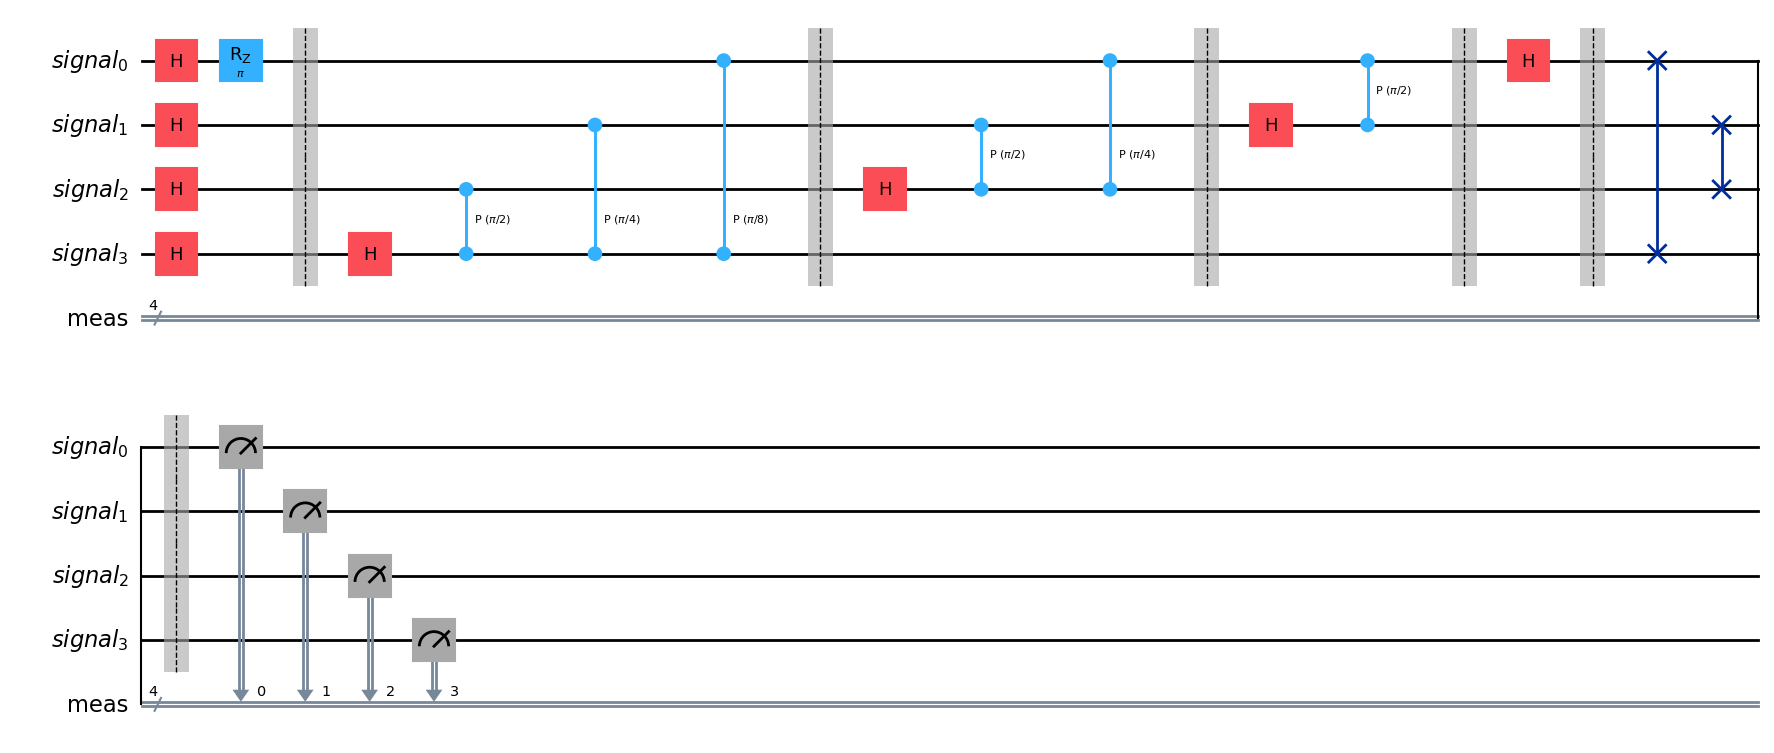

In [ ]:
#Pruebo con la señal A
s='A' #señal
n= 4 #qubits

#Creo el circuito con la señal A
circuitoA = crear_señal(s)
qft_n_qubits(circuitoA, n)

circuitoA.measure_all()

display(circuitoA.draw('mpl'))

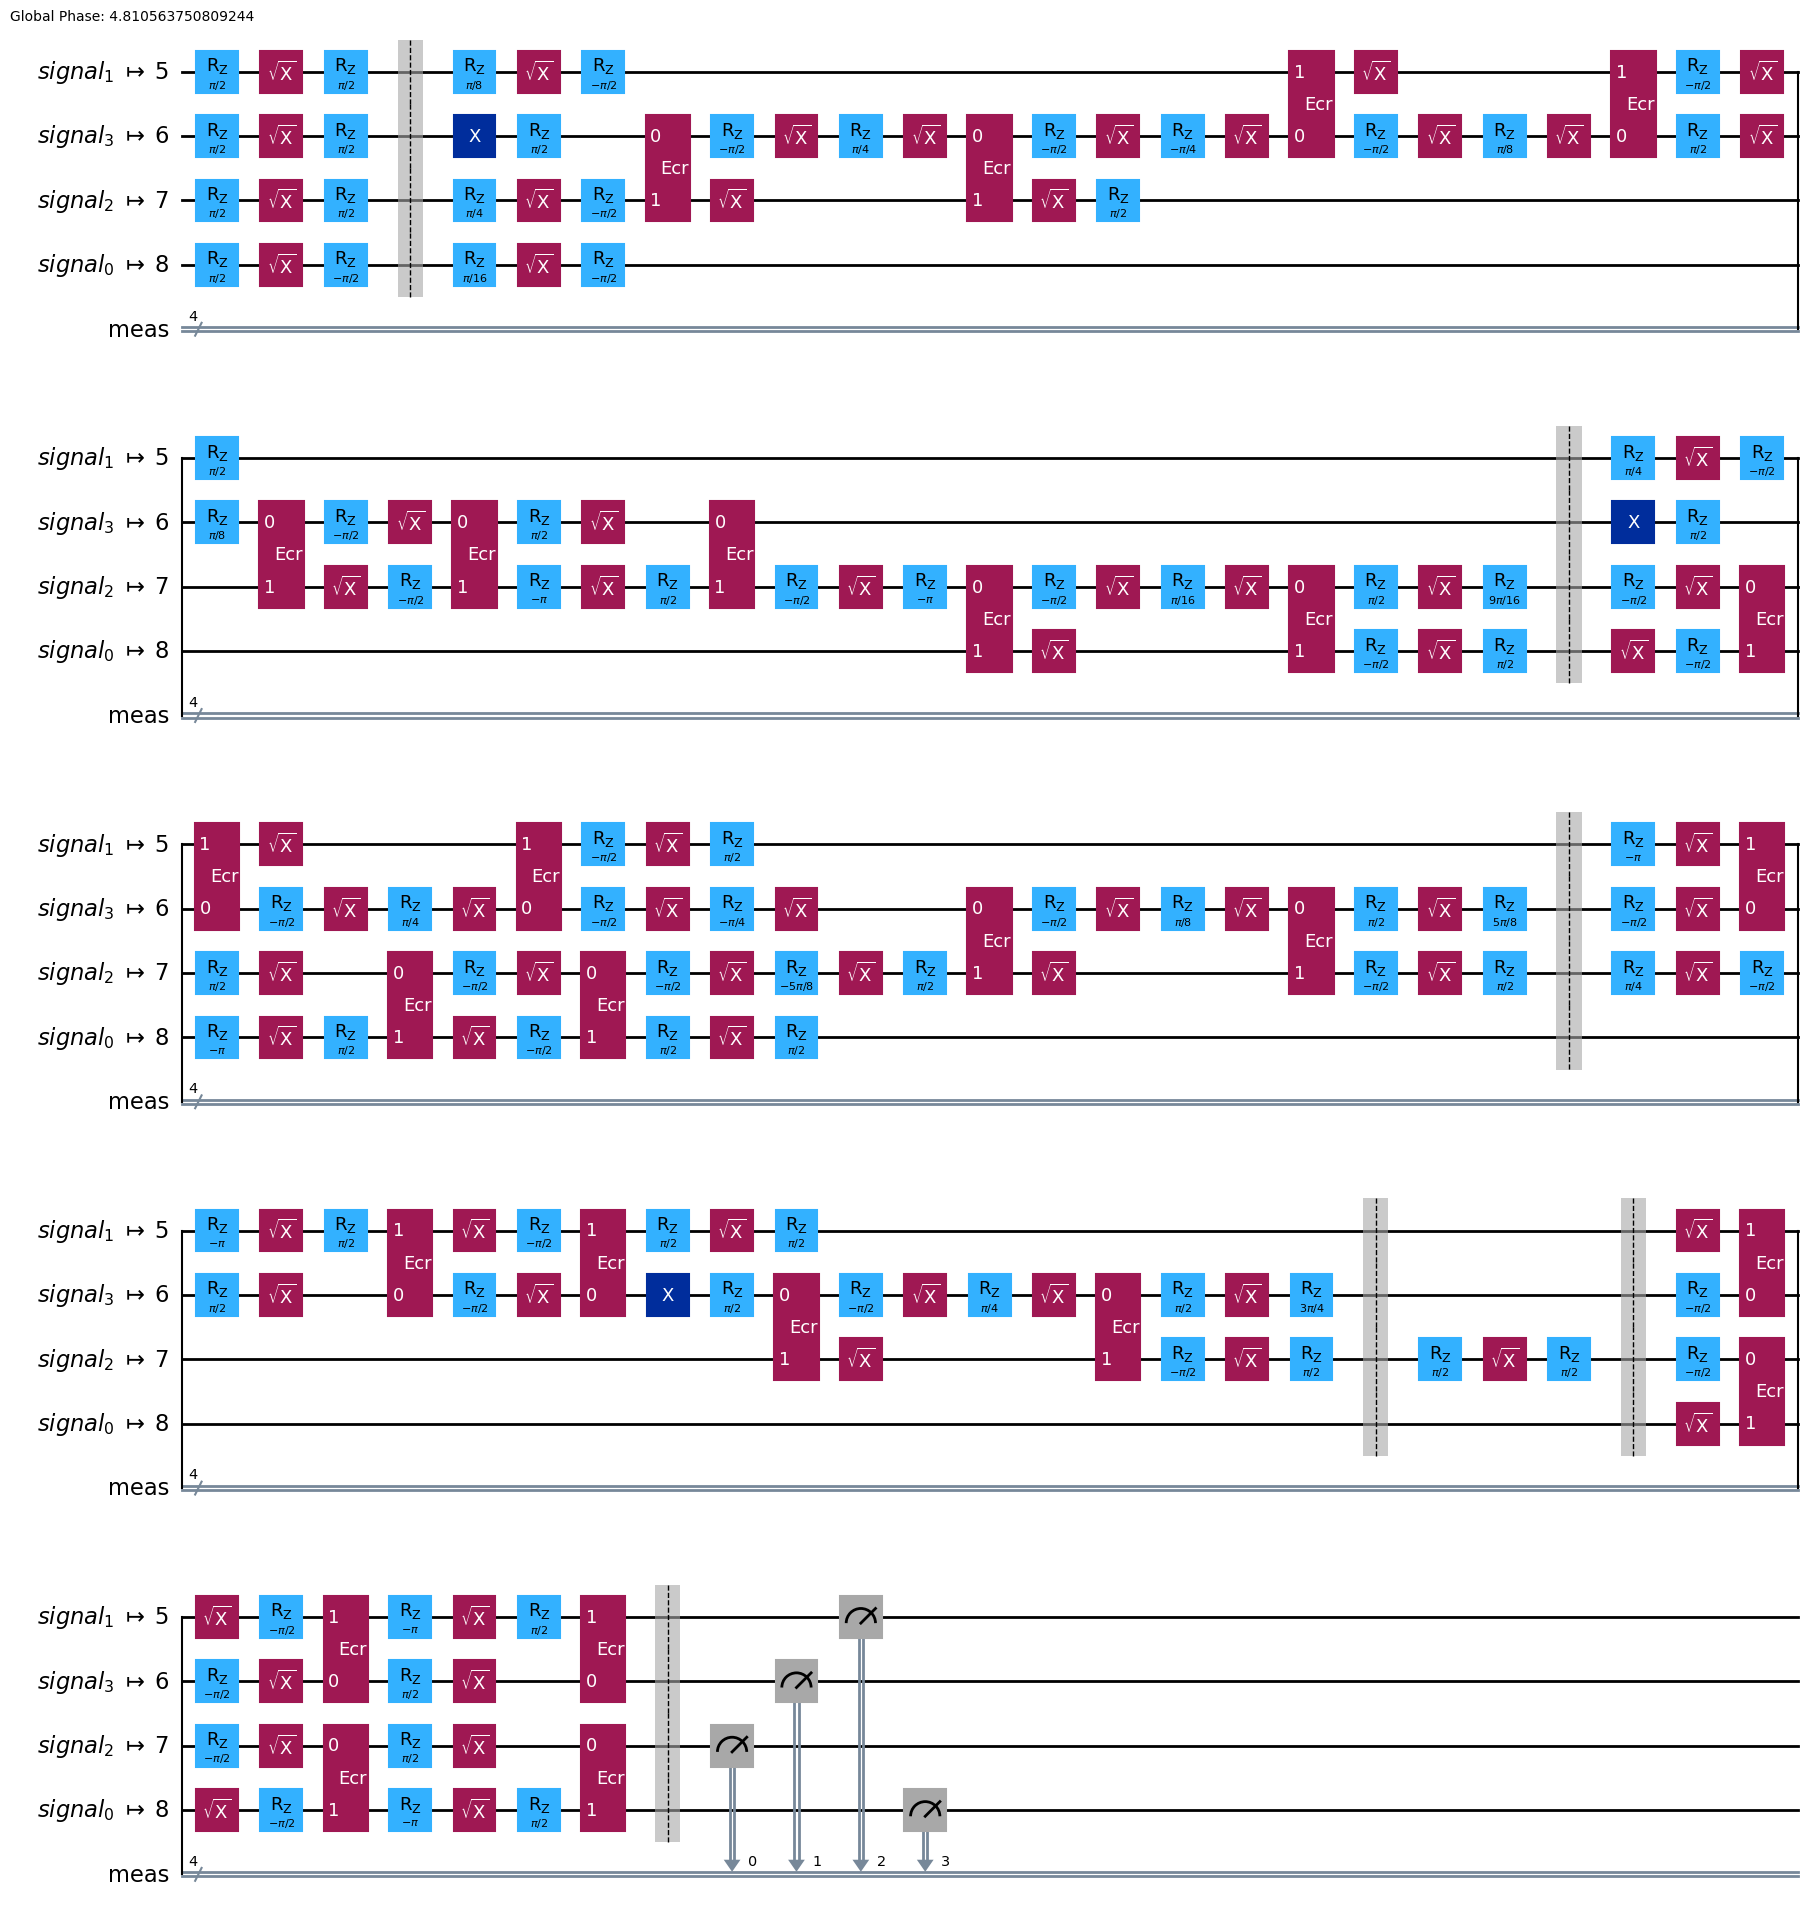

In [143]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuitoA)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

In [144]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=1000)
print(f"job id: {job.job_id()}")
result = job.result()

job id: czg4zf5aejkg008c7z20


{'1110': 11, '1000': 536, '0000': 188, '0100': 47, '0011': 10, '0110': 45, '1010': 43, '0001': 38, '1100': 10, '0010': 37, '0101': 2, '1001': 16, '0111': 8, '1111': 5, '1011': 2, '1101': 2}


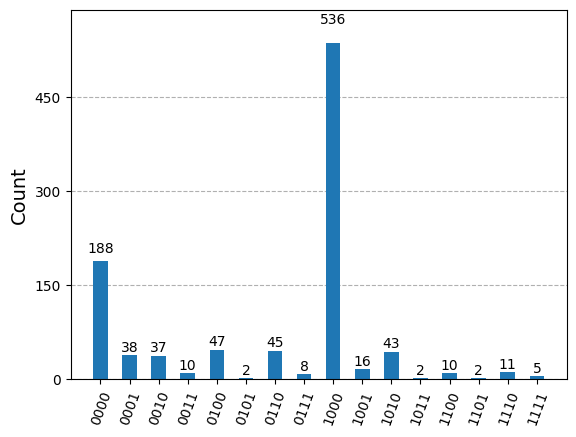

In [145]:
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

Para este ejercicio ejecuto el circuito en el computador cuántico real de IBM.
He probado para los circuitos con QFT para la seña A y la señal C.\
La razón es porque al ejecutarlo primero con la señal C he obtenido gráficas muy parecido al que se ve arriba.

En la backend real veo que el qubit 3 (el más significativo) del circuito tiene más errores.\
Como se ve en el caso de la señal C, las mediciones mayoritarias son $\ket{0010}$ y $\ket{1010}$. En ambos casos se obtiene un 2 lógico si solo tenemos en cuenta los 3 bits menos significativos. El qubit más significativo falla al ejecutarlos en el computador.\ 
Podemos concluir que el circuito también funciona en una backend real.

Luego, tras ejecutar la señal A con QFT en el computador cuántico obtengo mayoritariamente $\ket{1000}$ que es la frecuencia correcta. No obstante, en el histograma también se observan bastantes mediciones del $\ket{0000}$. Está ocurriendo lo mismo que con la señal C, que se erra bastante en el qubit más significativo del circuito.

Para ejecutarlo he utilizado el código utilizado en prácticas anteriores.

## Anexo

#### QFT Recursión utilizado en la teoría de IBM

A continuación voy a implementar la QFT de manera recursiva tal y como lo explica IBM en sus apuntes de QPE: 
##### [Phase-estimation and factoring](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring)


En esta implementación construimos la $QFT$ para m qubits a partir de la $QFT$ de m - 1 qubits, con $SWAPS$ incluido.

In [ ]:
def qft_IBM_aux(circuito, i, n):
    
    if (i == n - 1): 
        circuito.h(circuito.qubits[n - 1])
        circuito.barrier()
    else:
        circuito = qft_IBM_aux(circuito, i + 1, n)
        
        for j in range(i + 1, n):
            circuito.cp(math.pi/2**(n - j), circuito.qubits[j], circuito.qubits[i])
            
        circuito.h(circuito.qubits[i])
        
        #A partir de aqui coloco los Swaps, para poner el qubit menos significativo como el que más
        #Además voy a mover los demás un bit a la derecha
        circuito.swap(circuito.qubits[i], circuito.qubits[n - 1])
        #Tras el Swap tengo el qubit más significativo como el menos
        #Esto me permite a continuacion mover los qubits a la derecha.
        #Paso de |y>|b> ---> |b>|y>
        
        #Aqui desplazo los qubits a la derecha
        for j in range (i, n - 2):
            circuito.swap(circuito.qubits[j], circuito.qubits[j + 1])
        
        circuito.barrier()
        
    
    return circuito

def qft_IBM(circuito, n): #Recibe el circuito y luego el numero de qubits
    circuito = qft_IBM_aux(circuito, 0, n)
    return circuito

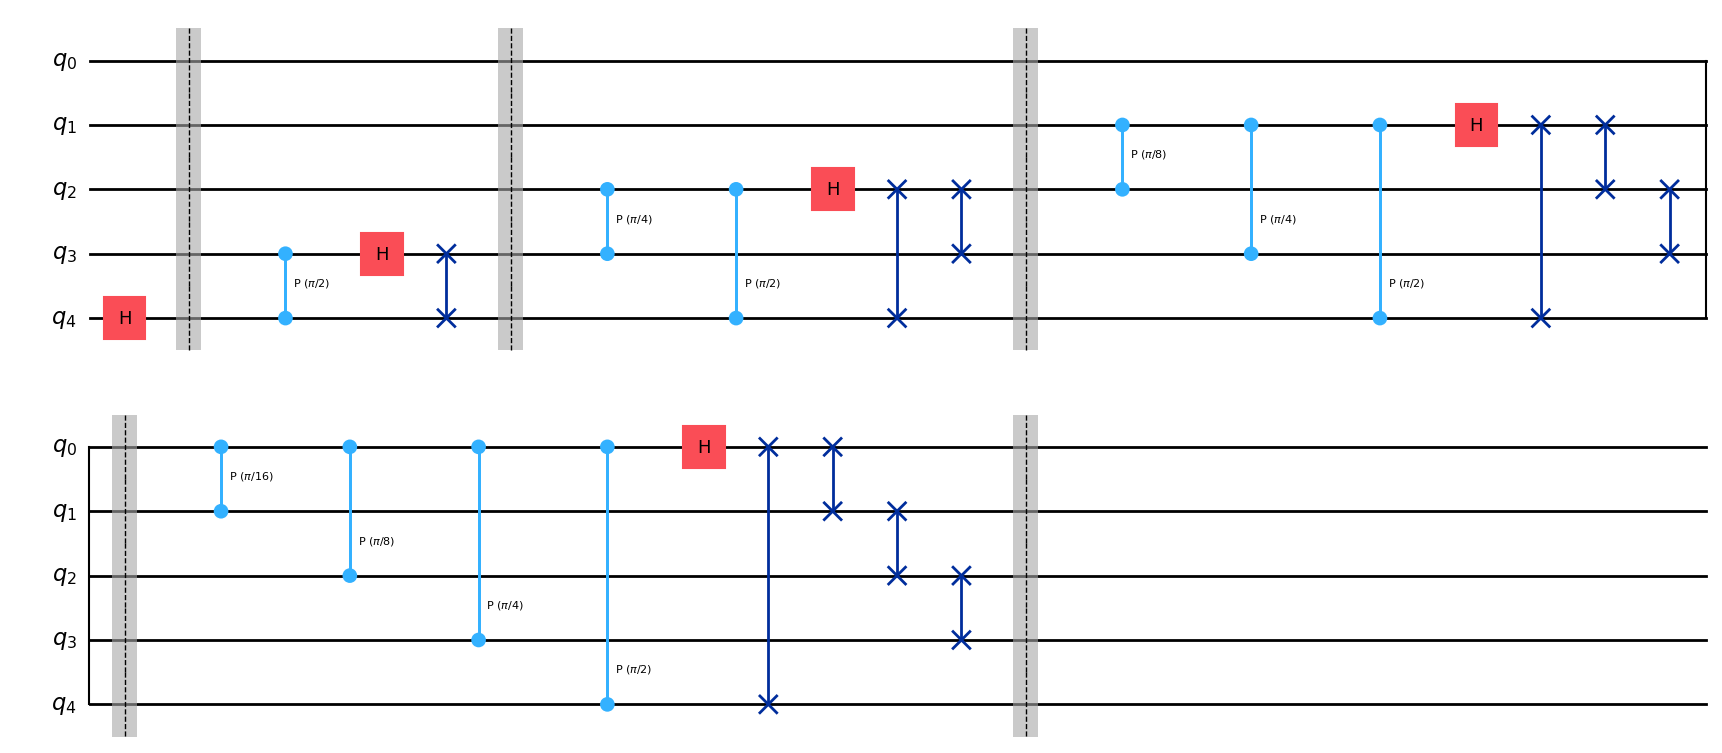

In [ ]:
circ_ibm = qft_IBM(QuantumCircuit(5), 5)

display(circ_ibm.draw('mpl'))

En esta funcion que he creado, construye una QFT para m qubits a partir de la QFT para m - 1 qubits aplicado sobre los qubits de 1 al m-1. Luego la QFT m - 1 se crea a partir de la QFT m - 2 aplicado sobre los qubits 2 al m - 1 del circuito original y así sucesivamente.\
Esta es la idea que he aplicado para implementar esta construcción de la QFT recursiva, que es la que se explica en la página de IBM Quantum Learning en la lección sobre QPE.

En la lección de IBM se demuestra que de esta manera también se puede implementar una QFT correctamente.\
Sabemos que:
$$QFT_{m}\ket{u} = \frac{1}{\sqrt{2^{m}}}\sum_{y=0}^{2^{m} - 1}\omega_{2^{m}}^{uv} \vert v \rangle$$

Sea $\ket{q_{m-1}q_{m-2}...q_{1}q_0} = \ket{x}\ket{q_0}$. Entonces:
- Primero aplicamos la QFT sobre los m - 1 qubits más significativos:
$$(QFT_{m-1}\ket{x})\ket{q_0} = \frac{1}{\sqrt{2^{m-1}}}\sum_{y=0}^{2^{m- 1}-1}\omega_{2^{m-1}}^{xy} \vert y \rangle \vert q_0 \rangle$$
- A continuación aplico las puertas de cambio de fase y la Hadamard final obtengo:
$$\frac{1}{\sqrt{2^{m}}}\sum_{y=0}^{2^{m}-1}\sum_{b=0}^{1}(-1)^{q_{0}b}\omega_{2^{m-1}}^{xy}\omega_{2^{m}}^{q_{0}y} \vert y \rangle \vert b \rangle$$
- Ahora movemos el qubit menos significativo al más signicifativo con los SWAPS:
$$\frac{1}{\sqrt{2^{m}}}\sum_{y=0}^{2^{m}-1}\sum_{b=0}^{1}(-1)^{q_{0}b}\omega_{2^{m-1}}^{xy}\omega_{2^{m}}^{q_{0}y} \vert b \rangle \vert y \rangle$$
- Ahora solo basta con demostrar que:
$$(-1)^{q_{0}b}\omega_{2^{m-1}}^{xy}\omega_{2^{m}}^{q_{0}y} = \omega_{2^{m}}^{(2x + q_0)(2^{m-1}b + y)}$$
- Además: 
$$\ket{x}\ket{q_0} = \ket{2x + q_0}$$
$$\ket{b}\ket{y} = \ket{2^{m-1}b + y}$$

En el caso del circuito que he hecho. Para una $QFT$ para n qubits, tiene n barreras.\
Hasta la barrera i tenemos una $QFT$ para i qubits.
